# 00.Importing Libraries

In [26]:
#!pip install --quiet prophet
#!pip install --quiet plotly

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from prophet import Prophet
import plotly.express as px
from prophet.plot import plot_plotly
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error

# 01.Helpers

## Constants

In [28]:
features = ['date', 'hospitalizations', 'heat_index', 'heat_index_sum', 'heat_index_std', 'heat_index99','heat_index95', 'temperature_mean', 'temperature_max',
           'temperature_min', 'wind_speed_mean', 'humidity_mean','lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3']

feature_without_target = ['heat_index', 'heat_index_sum', 'heat_index_std', 'heat_index99','heat_index95', 'temperature_mean', 'temperature_max',
           'temperature_min', 'wind_speed_mean', 'humidity_mean','lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3']

## 01.02 Functions

In [29]:
def train_test_split(df, test_date, target_variable):
    # separação por tempo
    df_train = df[df.index < test_date]
    df_test  = df[df.index >= test_date]

    # remoção da variável target
    y_train = df_train[target_variable]
    y_test  = df_test[target_variable]

    df_train = df_train.drop(columns=target_variable).copy()
    df_test  = df_test.drop(columns=target_variable).copy()

    print(df_train.shape, y_train.shape)
    print(df_test.shape, y_test.shape)

    return df_train, df_test, y_train, y_test

In [30]:
def data_normalization(df_train, df_test, y_train, y_test):
    # Para as features
    scaler               = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled      = scaler.fit_transform(df_train)
    df_test_scaled       = scaler.transform(df_test)

    # Para a variável alvo
    scaler_target       = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled      = scaler_target.fit_transform(y_train.to_frame())
    y_test_scaled       = scaler_target.transform(y_test.to_frame())

    print(df_train_scaled.shape, y_train_scaled.shape)
    print(df_test_scaled.shape, y_test_scaled.shape)

    return scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled

In [31]:
def data_reconversion(scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled, y_pred):
    df_train_original = scaler.inverse_transform(df_train_scaled)
    df_test_original = scaler.inverse_transform(df_test_scaled)

    y_train_original = scaler_target.inverse_transform(y_train_scaled)
    y_test_original = scaler_target.inverse_transform(y_test_scaled)
    y_pred_original = scaler_target.inverse_transform(y_pred)

    return df_train_original, df_test_original, y_train_original, y_test_original, y_pred_original

In [32]:
def metrics(y, predicted):
    mae = mean_absolute_error(y, predicted)
    mse = mean_squared_error(y, predicted)
    rmse = mean_squared_error(y, predicted)
    mape = np.mean(np.abs((y - predicted) / y)) * 100
    r2 = r2_score(y, predicted)
    return mae, mse, rmse, mape, r2

def print_metrics(y, predicted):
    mae, mse, rmse, mape, r2 = metrics(y, predicted)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-Squared (R²): {r2:.2f}")

In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance_prophet(model, df, regressors, y_true, metric=mean_squared_error):
    """
    Calculates Permutation Feature Importance for a Prophet model.

    Parameters:
        model: Trained Prophet model.
        df: DataFrame containing the input data, including regressors.
        regressors: List of exogenous variables (regressors) used in the model.
        y_true: True values of the target variable.
        metric: Metric function to evaluate model performance (default: MSE).

    Returns:
        importances: Dictionary with feature importance scores for each regressor.
    """
    # Predict the baseline performance
    baseline_pred = model.predict(df)['yhat']
    baseline_score = metric(y_true, baseline_pred)
    importances = {}

    # Iterate over each regressor
    for regressor in regressors:
        df_permuted = df.copy()
        # Permute the values of the current regressor
        df_permuted[regressor] = np.random.permutation(df_permuted[regressor])
        
        # Predict with the permuted data
        permuted_pred = model.predict(df_permuted)['yhat']
        permuted_score = metric(y_true, permuted_pred)
        
        # Importance = difference between the original and permuted scores
        importance = permuted_score - baseline_score
        importances[regressor] = importance
    
    return importances

In [34]:
import matplotlib.pyplot as plt

def plot_permutation_importance(importances):
    """
    Plots feature importance scores as a horizontal bar chart.
    
    Parameters:
        importances: Dictionary with feature names as keys and importance scores as values.
    """
    # Sort the importances in descending order
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*sorted_importances)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(features, scores, color="skyblue")
    plt.xlabel("Permutation Importance (Change in Metric)")
    plt.title("Permutation Feature Importance for Prophet Model")
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature on top
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.show()

# 02.Importing Dataset

In [35]:
dataset = pd.read_csv('../../Preprocessing/dataset.csv', 
                   header=0, 
                   index_col=0,
                   usecols=features)

dataset

hospitalizations  heat_index  heat_index_sum  heat_index_std  \
date                                                                       
2000-12-01            4266.0   24.154261        17970.77        4.999719   
2001-01-01            4032.0   26.316156        19579.22        4.452698   
2001-02-01            3888.0   27.119464        18224.28        4.274063   
2001-03-01            3658.0   26.113387        19428.36        4.220196   
2001-04-01            4022.0   21.383903        15396.41        3.427034   
...                      ...         ...             ...             ...   
2024-05-01            3172.0   16.708185        12430.89        5.357643   
2024-06-01            3640.0   17.283889        12444.40        5.390826   
2024-07-01            3689.0   13.313495         9905.24        4.740495   
2024-08-01            3846.0   15.274395        11364.15        5.299870   
2024-09-01            3426.0   18.789722        13528.60        4.423471   

            heat_index99  heat_index95  temperature_mean  temperature_max  \
date                                                                        
2000-12-01       37.8966       33.5380         23.575000             35.4   
2001-01-01       37.8471       34.6685         25.136962             35.4   
2001-02-01       37.7548       35.3940         25.691071             34.2   
2001-03-01       36.7670       34.4155         24.985349             34.4   
2001-04-01       31.0030       28.0215         21.038333             30.8   
...                  ...           ...               ...              ...   
2024-05-01       33.1822       27.3330         16.684946             32.5   
2024-06-01       29.7834       26.8025         17.371111             31.5   
2024-07-01       26.8167       21.7780         13.736022             28.9   
2024-08-01       28.9485       24.4525         15.594758             31.1   
2024-09-01       31.8239       26.9330         18.740278             33.7   

            temperature_min  wind_speed_mean  humidity_mean  lag_heat_index_1  \
date                                                                            
2000-12-01             13.4         1.826613      70.836022         21.132403   
2001-01-01             17.0         1.777016      75.375000         24.154261   
2001-02-01             20.2         1.916518      76.424107         26.316156   
2001-03-01             16.3         1.629704      76.383065         27.119464   
2001-04-01             11.9         1.455139      81.152778         26.113387   
...                     ...              ...            ...               ...   
2024-05-01              7.1         1.345027      85.837366         22.136556   
2024-06-01              4.6         1.265139      80.636111         16.708185   
2024-07-01              3.4         1.123387      81.887097         17.283889   
2024-08-01              4.5         1.394892      78.956989         13.313495   
2024-09-01              9.0         1.534722      80.148611         15.274395   

            lag_heat_index_2  lag_heat_index_3  
date                                            
2000-12-01         19.318992         15.300694  
2001-01-01         21.132403         19.318992  
2001-02-01         24.154261         21.132403  
2001-03-01         26.316156         24.154261  
2001-04-01         27.119464         26.316156  
...                      ...               ...  
2024-05-01         25.621075         27.636221  
2024-06-01         22.136556         25.621075  
2024-07-01         16.708185         22.136556  
2024-08-01         17.283889         16.708185  
2024-09-01         13.313495         17.283889  

[286 rows x 14 columns]

In [36]:
dataset.index = pd.to_datetime(dataset.index)

dataset.head(5)

hospitalizations  heat_index  heat_index_sum  heat_index_std  \
date                                                                       
2000-12-01            4266.0   24.154261        17970.77        4.999719   
2001-01-01            4032.0   26.316156        19579.22        4.452698   
2001-02-01            3888.0   27.119464        18224.28        4.274063   
2001-03-01            3658.0   26.113387        19428.36        4.220196   
2001-04-01            4022.0   21.383903        15396.41        3.427034   

            heat_index99  heat_index95  temperature_mean  temperature_max  \
date                                                                        
2000-12-01       37.8966       33.5380         23.575000             35.4   
2001-01-01       37.8471       34.6685         25.136962             35.4   
2001-02-01       37.7548       35.3940         25.691071             34.2   
2001-03-01       36.7670       34.4155         24.985349             34.4   
2001-04-01       31.0030       28.0215         21.038333             30.8   

            temperature_min  wind_speed_mean  humidity_mean  lag_heat_index_1  \
date                                                                            
2000-12-01             13.4         1.826613      70.836022         21.132403   
2001-01-01             17.0         1.777016      75.375000         24.154261   
2001-02-01             20.2         1.916518      76.424107         26.316156   
2001-03-01             16.3         1.629704      76.383065         27.119464   
2001-04-01             11.9         1.455139      81.152778         26.113387   

            lag_heat_index_2  lag_heat_index_3  
date                                            
2000-12-01         19.318992         15.300694  
2001-01-01         21.132403         19.318992  
2001-02-01         24.154261         21.132403  
2001-03-01         26.316156         24.154261  
2001-04-01         27.119464         26.316156

In [37]:
dataset.columns

Index(['hospitalizations', 'heat_index', 'heat_index_sum', 'heat_index_std',
       'heat_index99', 'heat_index95', 'temperature_mean', 'temperature_max',
       'temperature_min', 'wind_speed_mean', 'humidity_mean',
       'lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3'],
      dtype='object')

# 03.Preprocessing

## 03.01 Remoção ano 2000

In [38]:
dataset = dataset[dataset.index < "2020-01-01"]

test_start_date = '2017-01-01'

# 04.Model training

## 04.01 Split train and test

In [39]:
df_train, df_test, y_train, y_test = train_test_split(dataset, test_start_date, 'hospitalizations')

(193, 13) (193,)
(36, 13) (36,)


## 04.02 Normalization

In [40]:
scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled = data_normalization(df_train, df_test, y_train, y_test)

(193, 13) (193, 1)
(36, 13) (36, 1)


## 04.03 Prophet

In [41]:
df = pd.DataFrame({
        'ds': df_train.index,
        'y': y_train_scaled.reshape(-1),
        'heat_index': df_train_scaled[:, 0],
        'heat_index_sum': df_train_scaled[:, 1],
        'heat_index_std': df_train_scaled[:, 2], 
        'heat_index99': df_train_scaled[:, 3], 
        'heat_index95': df_train_scaled[:, 4], 
        'temperature_mean': df_train_scaled[:, 5],
        'temperature_max': df_train_scaled[:, 6], 
        'temperature_min': df_train_scaled[:, 7], 
        'wind_speed_mean': df_train_scaled[:, 8],
        'humidity_mean': df_train_scaled[:, 9], 
        'lag_heat_index_1': df_train_scaled[:, 10], 
        'lag_heat_index_2': df_train_scaled[:, 11],
        'lag_heat_index_3': df_train_scaled[:, 12],
    })

df

ds         y  heat_index  heat_index_sum  heat_index_std  \
0   2000-12-01  0.740031    0.770204        0.780005        0.501985   
1   2001-01-01  0.618850    0.897163        0.905181        0.366833   
2   2001-02-01  0.544278    0.944338        0.799734        0.322697   
3   2001-03-01  0.425168    0.885255        0.893440        0.309388   
4   2001-04-01  0.613672    0.607513        0.579658        0.113422   
..         ...       ...         ...             ...             ...   
188 2016-08-01  0.350596    0.293436        0.309933        0.497155   
189 2016-09-01  0.293112    0.292726        0.279305        0.252823   
190 2016-10-01  0.461937    0.486140        0.499931        0.286368   
191 2016-11-01  0.342310    0.589563        0.562532        0.535445   
192 2016-12-01  0.176075    0.840626        0.849438        0.561428   

     heat_index99  heat_index95  temperature_mean  temperature_max  \
0        0.769188      0.694720          0.803586         0.740541   
1        0.767183      0.740995          0.908859         0.740541   
2        0.763444      0.770692          0.946205         0.675676   
3        0.723434      0.730639          0.898641         0.686486   
4        0.489969      0.468911          0.632621         0.491892   
..            ...           ...               ...              ...   
188      0.521372      0.331662          0.309663         0.572973   
189      0.354661      0.294556          0.311780         0.513514   
190      0.461770      0.429902          0.511439         0.572973   
191      0.632118      0.557675          0.623316         0.702703   
192      0.833840      0.752108          0.860277         0.875676   

     temperature_min  wind_speed_mean  humidity_mean  lag_heat_index_1  \
0           0.643564         0.649677       0.271381          0.592743   
1           0.821782         0.614071       0.470696          0.770204   
2           0.980198         0.714222       0.516764          0.897163   
3           0.787129         0.508313       0.514962          0.944338   
4           0.569307         0.382989       0.724409          0.885255   
..               ...              ...            ...               ...   
188         0.306931         0.178688       0.678392          0.168190   
189         0.415842         0.538339       0.603529          0.293436   
190         0.450495         0.673994       0.611580          0.292726   
191         0.470297         0.435537       0.368357          0.486140   
192         0.707921         0.464022       0.354070          0.589563   

     lag_heat_index_2  lag_heat_index_3  
0            0.486249          0.250271  
1            0.592743          0.486249  
2            0.770204          0.592743  
3            0.897163          0.770204  
4            0.944338          0.897163  
..                ...               ...  
188          0.000000          0.227038  
189          0.168190          0.000000  
190          0.293436          0.168190  
191          0.292726          0.293436  
192          0.486140          0.292726  

[193 rows x 15 columns]

## 04.03.01 Training

In [42]:
model = Prophet()

# Add exogenous variables as regressors
model.add_regressor('heat_index')
model.add_regressor('heat_index_sum')
model.add_regressor('heat_index_std')
model.add_regressor('heat_index99')
model.add_regressor('heat_index95')
model.add_regressor('temperature_mean')
model.add_regressor('temperature_max')
model.add_regressor('temperature_min')
model.add_regressor('wind_speed_mean')
model.add_regressor('humidity_mean')
model.add_regressor('lag_heat_index_1')
model.add_regressor('lag_heat_index_2')
model.add_regressor('lag_heat_index_3')

model.fit(df)

05:38:58 - cmdstanpy - INFO - Chain [1] start processing
05:38:58 - cmdstanpy - INFO - Chain [1] done processing


### 04.03.02 Forecasting

In [43]:
df_test_scaled[:, 0]

array([0.93642262, 1.00261732, 0.77334092, 0.56077753, 0.44504477,
       0.29207275, 0.31799893, 0.37427229, 0.5619757 , 0.53445243,
       0.5728416 , 0.81017478, 0.85303988, 0.79343638, 0.74820249,
       0.75556692, 0.41338099, 0.11157657, 0.19313004, 0.15652667,
       0.48536056, 0.53730189, 0.70618342, 0.82256956, 1.05126075,
       0.85758819, 0.74448082, 0.6709406 , 0.49222984, 0.43883178,
       0.127339  , 0.24019277, 0.33107484, 0.57490061, 0.67822178,
       0.83984157])

In [44]:
future = model.make_future_dataframe(periods=len(df_test_scaled), freq='ME')

# Add exogenous variables as regressors
future['heat_index'] = np.concatenate((df_train_scaled[:, 0], df_test_scaled[:, 0]))
future['heat_index_sum'] = np.concatenate((df_train_scaled[:, 1], df_test_scaled[:, 1]))
future['heat_index_std'] = np.concatenate((df_train_scaled[:, 2], df_test_scaled[:, 2]))
future['heat_index99'] = np.concatenate((df_train_scaled[:, 3], df_test_scaled[:, 3]))
future['heat_index95'] = np.concatenate((df_train_scaled[:, 4], df_test_scaled[:, 4]))
future['temperature_mean'] = np.concatenate((df_train_scaled[:, 5], df_test_scaled[:, 5]))
future['temperature_max'] = np.concatenate((df_train_scaled[:, 6], df_test_scaled[:, 6]))
future['temperature_min'] = np.concatenate((df_train_scaled[:, 7], df_test_scaled[:, 7]))
future['wind_speed_mean'] = np.concatenate((df_train_scaled[:, 8], df_test_scaled[:, 8]))
future['humidity_mean'] = np.concatenate((df_train_scaled[:, 9], df_test_scaled[:, 9]))
future['lag_heat_index_1'] = np.concatenate((df_train_scaled[:, 10], df_test_scaled[:, 10]))
future['lag_heat_index_2'] = np.concatenate((df_train_scaled[:, 11], df_test_scaled[:, 11]))
future['lag_heat_index_3'] = np.concatenate((df_train_scaled[:, 12], df_test_scaled[:, 12]))

# Generate forecasts
y_pred = model.predict(future)

In [45]:
y_pred = model.predict(future)

y_pred

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2000-12-01  0.748085    0.571115    0.786710     0.748085     0.748085   
1   2001-01-01  0.744421    0.552220    0.770729     0.744421     0.744421   
2   2001-02-01  0.740757    0.428365    0.640636     0.740757     0.740757   
3   2001-03-01  0.737448    0.524685    0.744826     0.737448     0.737448   
4   2001-04-01  0.733784    0.551192    0.762559     0.733784     0.733784   
..         ...       ...         ...         ...          ...          ...   
224 2019-07-31  0.214480    0.181303    0.390363     0.208410     0.220878   
225 2019-08-31  0.213642    0.204802    0.418979     0.207018     0.220393   
226 2019-09-30  0.212831    0.093975    0.305936     0.205887     0.219761   
227 2019-10-31  0.211994    0.134816    0.347578     0.204642     0.219235   
228 2019-11-30  0.211183    0.046666    0.251842     0.203466     0.218833   

     additive_terms  additive_terms_lower  additive_terms_upper  \
0         -0.070107             -0.070107             -0.070107   
1         -0.085107             -0.085107             -0.085107   
2         -0.201835             -0.201835             -0.201835   
3         -0.104792             -0.104792             -0.104792   
4         -0.077325             -0.077325             -0.077325   
..              ...                   ...                   ...   
224        0.073946              0.073946              0.073946   
225        0.096546              0.096546              0.096546   
226       -0.011776             -0.011776             -0.011776   
227        0.033277              0.033277              0.033277   
228       -0.067331             -0.067331             -0.067331   

     extra_regressors_additive  ...  wind_speed_mean  wind_speed_mean_lower  \
0                    -0.069361  ...        -0.006400              -0.006400   
1                    -0.060037  ...        -0.005212              -0.005212   
2                    -0.166886  ...        -0.008553              -0.008553   
3                    -0.069262  ...        -0.001685              -0.001685   
4                    -0.011599  ...         0.002495               0.002495   
..                         ...  ...              ...                    ...   
224                   0.057461  ...         0.003554               0.003554   
225                   0.067655  ...         0.002545               0.002545   
226                   0.041473  ...        -0.002046              -0.002046   
227                  -0.038464  ...        -0.000555              -0.000555   
228                  -0.098147  ...        -0.003671              -0.003671   

     wind_speed_mean_upper    yearly  yearly_lower  yearly_upper  \
0                -0.006400 -0.000745     -0.000745     -0.000745   
1                -0.005212 -0.025070     -0.025070     -0.025070   
2                -0.008553 -0.034949     -0.034949     -0.034949   
3                -0.001685 -0.035530     -0.035530     -0.035530   
4                 0.002495 -0.065725     -0.065725     -0.065725   
..                     ...       ...           ...           ...   
224               0.003554  0.016485      0.016485      0.016485   
225               0.002545  0.028892      0.028892      0.028892   
226              -0.002046 -0.053249     -0.053249     -0.053249   
227              -0.000555  0.071742      0.071742      0.071742   
228              -0.003671  0.030816      0.030816      0.030816   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
224                   0.0                         0.0   
225                   0.0                       

In [46]:
print(y_pred[['ds', 'yhat', 'heat_index', 'heat_index_sum']])

            ds      yhat  heat_index  heat_index_sum
0   2000-12-01  0.677978   -0.180792        0.112420
1   2001-01-01  0.659314   -0.275741        0.166369
2   2001-02-01  0.538922   -0.311022        0.120923
3   2001-03-01  0.632656   -0.266836        0.161309
4   2001-04-01  0.656459   -0.059119        0.026074
..         ...       ...         ...             ...
224 2019-07-31  0.288426    0.215590       -0.112797
225 2019-08-31  0.310188    0.147621       -0.087603
226 2019-09-30  0.201055   -0.034730        0.029430
227 2019-10-31  0.245271   -0.112001        0.055151
228 2019-11-30  0.143852   -0.232872        0.142011

[229 rows x 4 columns]


### 04.03.03 Permutation Feature importance

In [47]:
regressors = df_test.columns  # List of regressors used in the model
y_true = df['y'].values  # True target values

# Call the function to calculate feature importance
importances = permutation_importance_prophet(model, df, regressors, y_true)

# Print the results
for regressor, importance in importances.items():
    print(f"Feature: {regressor}, Importance: {importance:.4f}")

Feature: heat_index, Importance: 0.0755
Feature: heat_index_sum, Importance: 0.0270
Feature: heat_index_std, Importance: 0.0003
Feature: heat_index99, Importance: 0.0033
Feature: heat_index95, Importance: 0.0008
Feature: temperature_mean, Importance: 0.0305
Feature: temperature_max, Importance: 0.0023
Feature: temperature_min, Importance: 0.0007
Feature: wind_speed_mean, Importance: 0.0002
Feature: humidity_mean, Importance: 0.0007
Feature: lag_heat_index_1, Importance: 0.0017
Feature: lag_heat_index_2, Importance: 0.0009
Feature: lag_heat_index_3, Importance: 0.0006


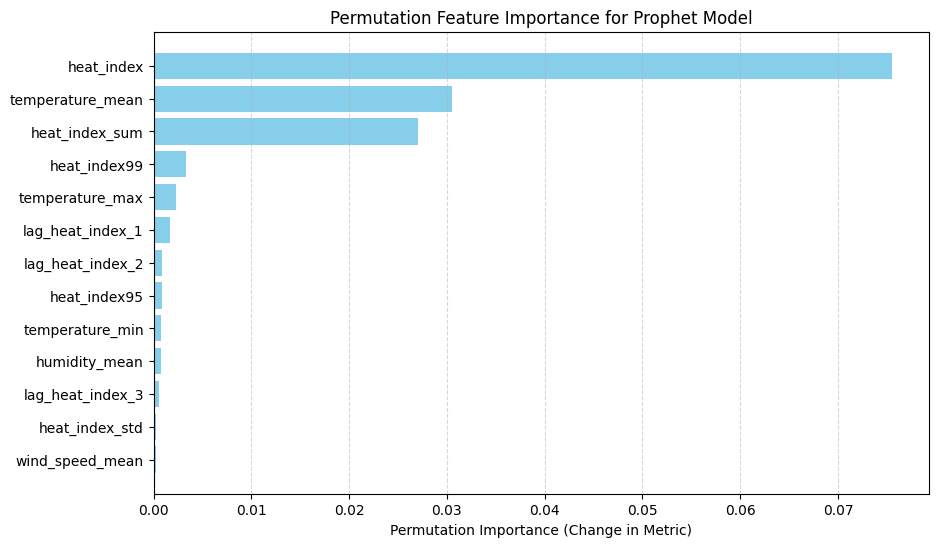

In [48]:
plot_permutation_importance(importances)

### 04.03.04 Metrics

**Metrics using test and train**

In [49]:
(
    df_train_original,
    df_test_original,
    y_train_original,
    y_test_original,
    y_pred_original
) = data_reconversion(
    scaler,
    scaler_target,
    df_train_scaled,
    df_test_scaled,
    y_train_scaled,
    y_test_scaled,
    y_pred['yhat'].values.reshape(-1, 1)
)

In [50]:
print_metrics(dataset['hospitalizations'].values.reshape(-1, 1), y_pred_original)

Mean Absolute Error (MAE): 126.39
Mean Squared Error (MSE): 26035.97
Root Mean Squared Error (RMSE): 26035.97
Mean Absolute Percentage Error (MAPE): 3.54%
R-Squared (R²): 0.82


**Metrics using only test**

In [51]:
(
    df_train_original,
    df_test_original,
    y_train_original,
    y_test_original,
    y_pred_original
) = data_reconversion(
    scaler,
    scaler_target,
    df_train_scaled,
    df_test_scaled,
    y_train_scaled,
    y_test_scaled,
    y_pred.tail(len(df_test_scaled))['yhat'].values.reshape(-1, 1)
)

In [52]:
print_metrics(y_test_original, y_pred_original)

Mean Absolute Error (MAE): 129.37
Mean Squared Error (MSE): 26560.13
Root Mean Squared Error (RMSE): 26560.13
Mean Absolute Percentage Error (MAPE): 3.94%
R-Squared (R²): 0.33


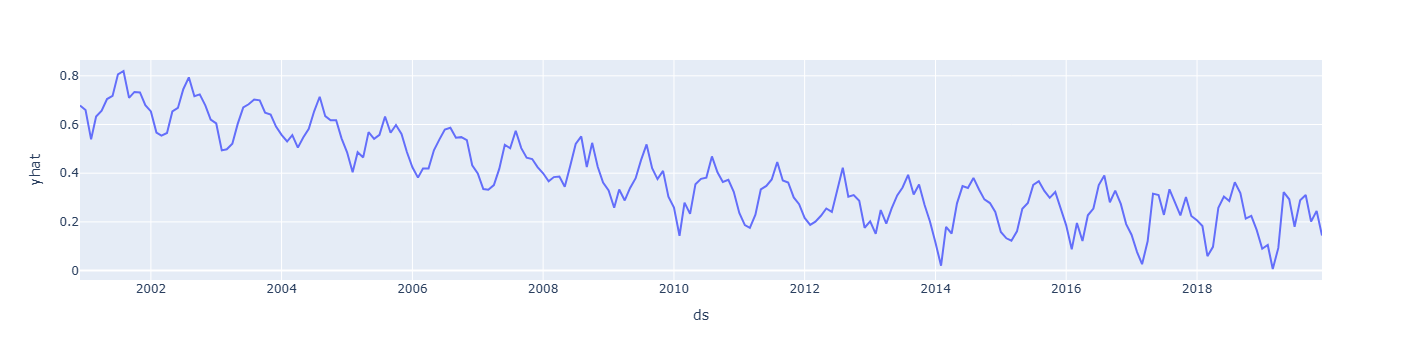

In [53]:
px.line(y_pred, x='ds', y='yhat')
# fig = px.line(y_pred, x='ds', y='yhat', title='Previsões do Prophet')
# fig.show()

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



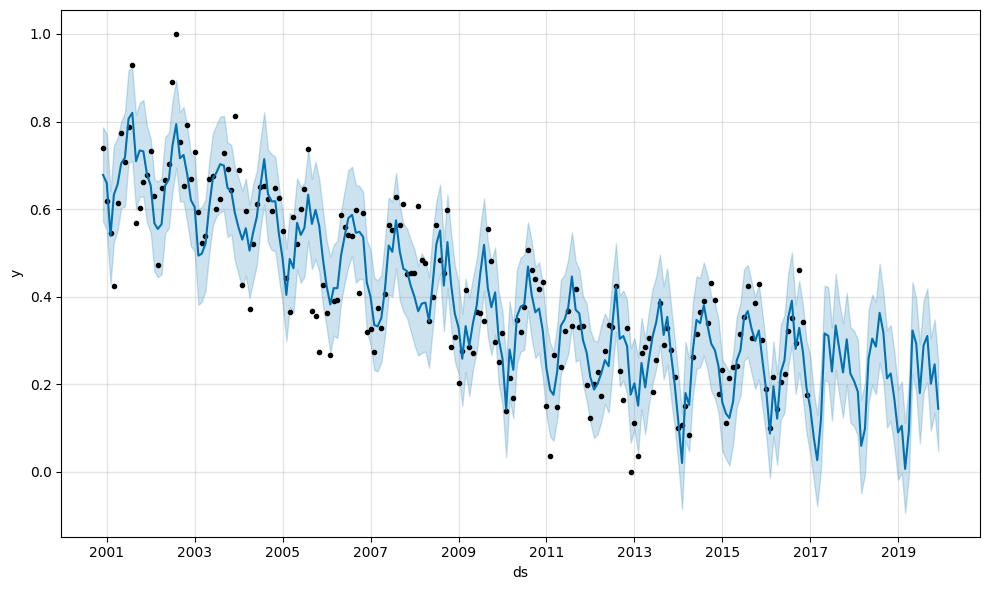

In [54]:
figure = model.plot(y_pred, xlabel='ds', ylabel='y')

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot

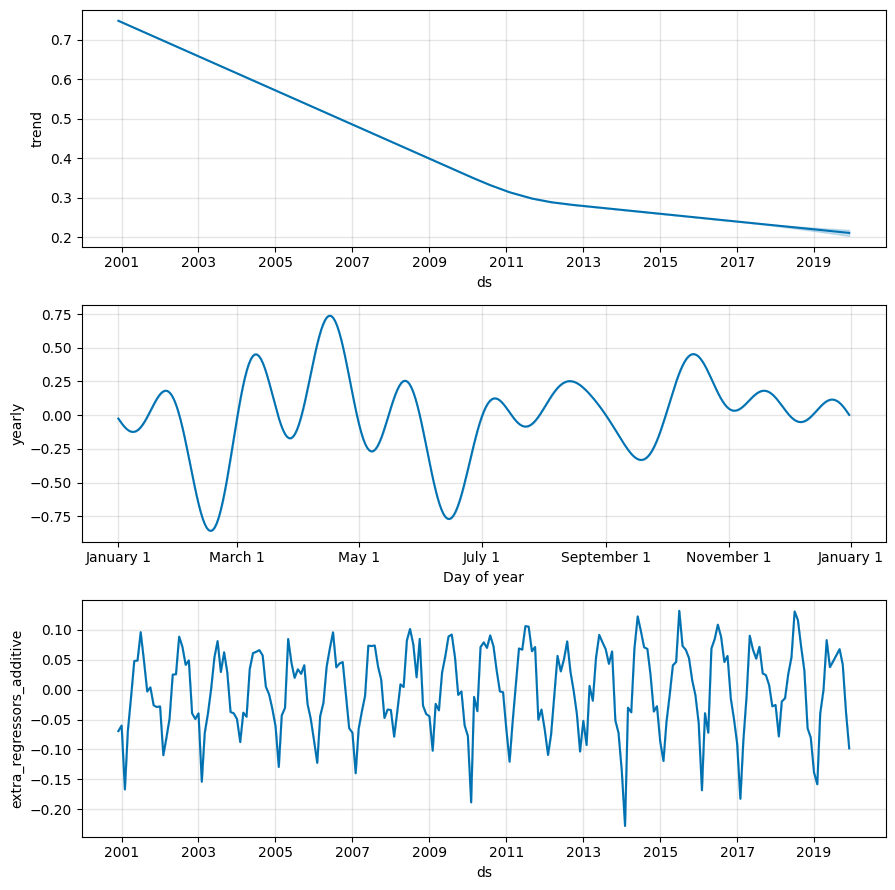

In [55]:
figure2 = model.plot_components(y_pred)

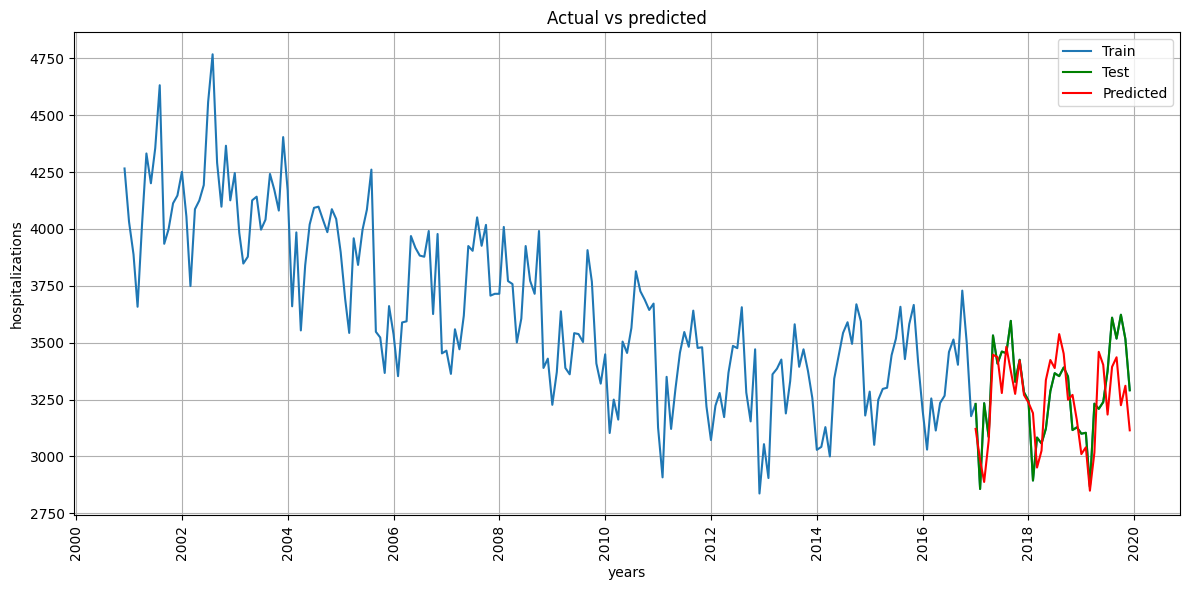

In [56]:
index = dataset[(dataset.index < test_start_date)].index
index_test = dataset[(dataset.index >= test_start_date)].index

plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['hospitalizations'], label='Train')
plt.plot(index_test, y_test_original, color='green', label='Test')
plt.plot(index_test, y_pred_original, color='red', label='Predicted')
plt.title("Actual vs predicted")
plt.xlabel('years')
plt.ylabel('hospitalizations')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Download the forecast data

In [57]:
y_pred.to_csv('forecast.csv')